# Deep Q Learning with Count

Building off of the Deep Q Learning framework, can I incorporate card count to improve the model?

In [1]:
import torch

torch.manual_seed(0)

In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
from copy import deepcopy

# Custom Modules.
from src.modules.game import Game

from src.deep_learning.modules import Net, Trainer
from src.deep_learning.utils import fill_value_tensor, gen_all_states, plot_mesh

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Evaluate card count distributions through game play

Distributions are mostly normal. However, they are more heavily centered towards 0, which makes sense given that card count resets upon shuffling. It would be more drastic if we didn't have a cut card (ratio_penetrate variable), as no matter what the count gets to during gameplay, the count is guaranteed to approach 0 at the end of the deck.

For this simple approach, I use random policy selection (of valid actions), and only assess card count once the initial deal is performed.

In [9]:
rules = {
    "dealer_hit_soft17": True,
    "push_dealer22": False,
    "double_after_split": True,
    "hit_after_split_aces": False,
    "reduced_blackjack_payout": False,
    "allow_surrender": True,
}

game_hyperparams = {
    "shrink_deck": True,
    "n_decks": 6,
    "ratio_penetrate": 2/3,
    "rules": rules
}

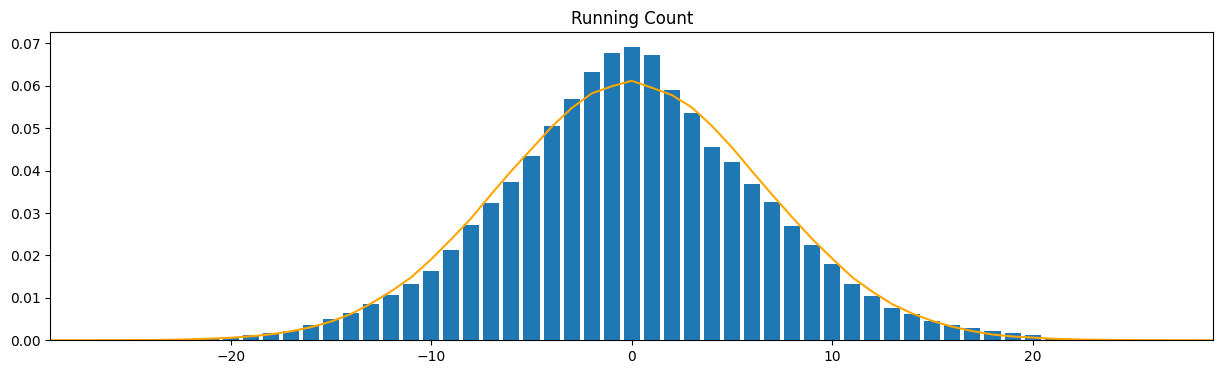

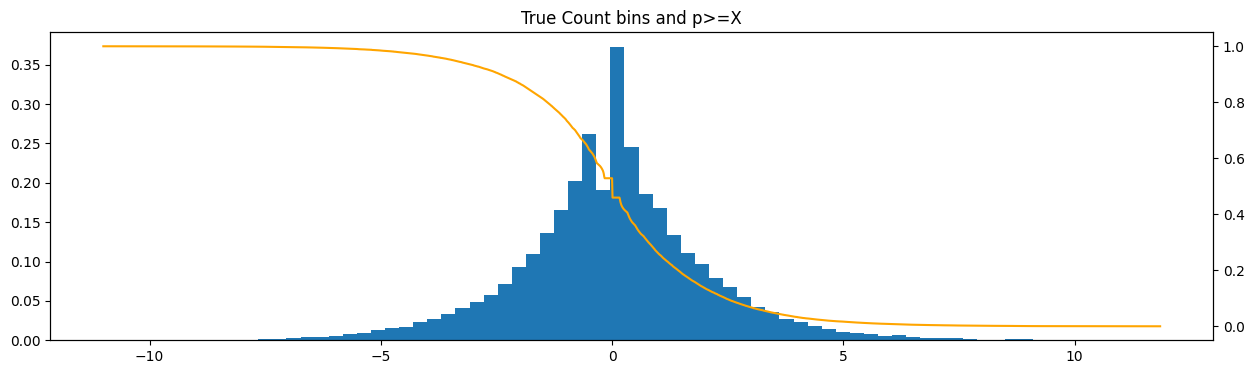

In [10]:
blackjack = Game(**game_hyperparams)
counts = []
true_counts = []

for _ in range(50_000) :
    
    blackjack.init_round(wagers=[1])
    blackjack.deal_init()
    player = blackjack.players[0] # only 1 player, so i'll just extract that specific player module.
    house_show = blackjack.get_house_show(show_value=True)

    # I'll extract counts after the initial deal.
    count = blackjack.get_count()
    true_count = count * 52 / blackjack.cards.sum()
    counts.append(count)
    true_counts.append(true_count)

    while not player.is_done() :

        player_show,useable_ace = player.get_value()

        policy = player.get_valid_moves()
        policy = [p for p in policy if p!='insurance']

        move = np.random.choice(policy)

        blackjack.step_player(player,move)

    blackjack.step_house()
    
plt.figure(figsize=(15,4))
plt.title("Running Count")
inds = np.argsort(pd.Series(counts).value_counts(normalize=True).index.to_list())
plt.bar(
    pd.Series(counts).value_counts(normalize=True).index[inds],
    pd.Series(counts).value_counts(normalize=True).values[inds]
)
samples = np.random.normal(0,np.array(counts).std(), 1_000_000)
minmax = max(abs(min(counts)), max(counts))
a, b = np.histogram(samples, np.arange(-minmax-1.5, minmax+1.5), density=True)
plt.plot([b[i-1:i+1].mean() for i in range(1,b.shape[0])], a, color="orange")
plt.xlim(-minmax, minmax)
plt.show()

ranges = np.arange(min(true_counts), max(true_counts)+0.01, 0.01)
y = []
for r in ranges:
    y.append(np.where(np.array(true_counts) >= r)[0].shape[0] / len(true_counts))

fig, ax1 = plt.subplots(figsize=(15,4))
ax1.set_title("True Count bins and p>=X")
ax2 = ax1.twinx()
ax1.hist(true_counts, bins=75, density=True)
ax2.plot(ranges, y, color="orange")
plt.show()


## Deep Q Learning Training Process

I'll follow the same approach as I did in the `Deep_Learning` notebook, by doing implicit action masking. I found that this led to better performance in practice, and really put an emphasis on the network learning which moves were feasible and which weren't.

**To handle Card Count, I take the following approach:**

Card count is ONLY computed after the initial deal, by default. If desired, the card count can be updated after each player move. However, I figure that once the count is set upon initial deal, the player's style of play is set for the round.\
The Game module is smart in that it accounts for the house's hidden card if the house had not played yet. In essensce, we never have a PERFECT idea of the card count, since there's always 1 card in play that players don't have access to. Once the house plays, the card count updates accordingly when `get_count()` is called

Since the `update_replay_buffer()` function can stop gameplay early upon invalid action selection, it was necessary to implement a `get_count()` method in the gameplay that is computed during each call, rather than continuously updating a class parameter.



In [16]:
REPLAY_SIZE = 10_000
MIN_REPLAY_SIZE = 5_000 # this won't be hit exactly due to splitting.
GAMMA = 0.99
LR = 0.0001
TARGET_UPDATE_FREQ = 1_000
N_EPOCHS = 1_000_000
EVAL_EVERY = 10_000
BATCH_SIZE = 32

EPS_MIN = .1
EPS_DECAY = - np.log(EPS_MIN) / (N_EPOCHS * 0.75)

USE_COUNT = True

In [17]:
hidden_layers = [100,50,20]

In [18]:
online_net = Net(6, hidden_layers=hidden_layers)
target_net = Net(6, hidden_layers=hidden_layers)

trainer = Trainer(
    online_net=online_net,
    target_net=target_net,
    lr=LR,
    replay_size=REPLAY_SIZE,
    include_count=USE_COUNT
)

trainer.copy_online_to_target()

blackjack = Game(**game_hyperparams)

In [19]:
mean_rewards = []
training_loss = []

replay_sufficient = False

for step in range(N_EPOCHS):
    print(f"Round {step}", end="\r")

    eps = max(EPS_MIN, np.exp(-EPS_DECAY * step))

    if not replay_sufficient:
        replay_sufficient = len(trainer.replay_buffer) >= MIN_REPLAY_SIZE

    if not replay_sufficient:
        method = "random"
    else:
        method = "random" if np.random.sample() < eps else "argmax"
        # mode = "softmax" # can comment this out if you which to use epsilon-greedy


    trainer.update_buffer(
        blackjack=blackjack,
        misstep_penalty=-1.5,
        method=method
    )

    if not replay_sufficient: continue

    loss_epoch = trainer.train_epoch(batch_size=BATCH_SIZE, gamma=GAMMA)

    training_loss.append(loss_epoch)

    if not step % TARGET_UPDATE_FREQ:
        trainer.copy_online_to_target()

    if (not step % EVAL_EVERY) or (step + 1 == N_EPOCHS):
        mean_reward = await trainer.eval(
            n_games=500,
            n_rounds=50,
            wagers=[1],
            game_hyperparams=game_hyperparams
        )
        mean_rewards.append(mean_reward)
        print(f"step {step}\
 ---- mean reward per round {mean_reward:.4f}\
 ---- epoch training loss {loss_epoch:.4f}\
 ---- eps {eps:.4f}")

network = Net(6, hidden_layers=hidden_layers)

network.load_state_dict(deepcopy(trainer.online_net.state_dict()))
network.eval()

step 10000 ---- mean reward per round -0.0560 ---- epoch training loss 0.3763 ---- eps 0.9698
step 20000 ---- mean reward per round -0.0497 ---- epoch training loss 0.5350 ---- eps 0.9404
step 30000 ---- mean reward per round -0.0300 ---- epoch training loss 0.0799 ---- eps 0.9120
step 40000 ---- mean reward per round -0.0410 ---- epoch training loss 0.3869 ---- eps 0.8844
step 50000 ---- mean reward per round -0.0477 ---- epoch training loss 0.1539 ---- eps 0.8577
step 60000 ---- mean reward per round -0.0480 ---- epoch training loss 0.2836 ---- eps 0.8318
step 70000 ---- mean reward per round -0.0469 ---- epoch training loss 0.2602 ---- eps 0.8066
step 80000 ---- mean reward per round -0.0438 ---- epoch training loss 0.2099 ---- eps 0.7822
step 90000 ---- mean reward per round -0.0476 ---- epoch training loss 0.3116 ---- eps 0.7586
step 100000 ---- mean reward per round -0.0412 ---- epoch training loss 0.1270 ---- eps 0.7356
step 110000 ---- mean reward per round -0.0264 ---- epoch t

TypeError: Net.__init__() takes from 2 to 3 positional arguments but 5 were given

In [21]:
torch.save(network.state_dict(), "./models/deep_q_count.pt")

In [1108]:
network = Net(6, hidden_layers=hidden_layers)

network.load_state_dict(torch.load("./models/deep_q_count.pt"))
network.eval()

Net(
  (fc_input): Linear(in_features=6, out_features=100, bias=True)
  (fc_hidden_1): Linear(in_features=100, out_features=50, bias=True)
  (fc_hidden_2): Linear(in_features=50, out_features=20, bias=True)
  (fc_output): Linear(in_features=20, out_features=4, bias=True)
)

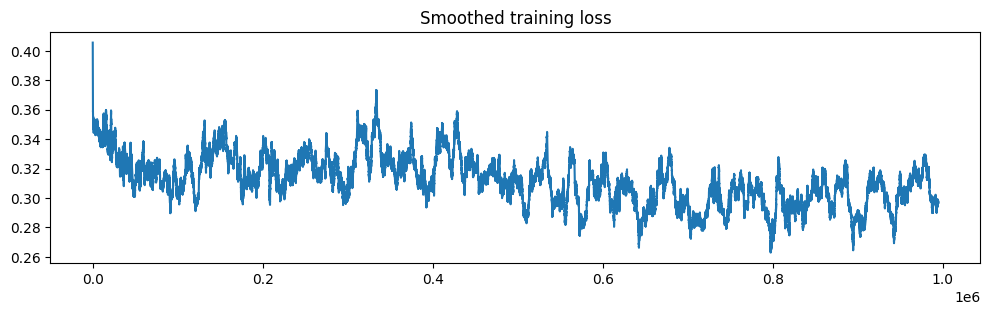

In [22]:
plt.figure(figsize=(12,3))
plt.plot(np.convolve(training_loss, np.ones(1000)/1000, mode="valid"))
plt.title("Smoothed training loss")
# plt.vlines(range(len(training_loss))[::1000], ymin=.25, ymax=.55)
plt.show()

## Evaluation

It's important to note that we are never changing our wager. Playing M games of N rounds each will mean we're going to approach the card count of 0 with high likelihood. Based off the plots above, the running count is roughly normally distributed, and the true count is more concentrated towards zero with shorter tails. I don't expect our performance to improve, on average, compared with the deep network without card count.

To really uncover what added benefit we get from including true count into our model, we'll need to break down performance a bit further.

#### Evaluation of Value Function

Fixing the true count to be a certain value, what does our value function look like? (It should look nearly identical to the value function in the `Deep_Learning` notebook). We can explore the value of being in a certain state, and see how it changes as the true count changes.

It seems intuitive that while having a 10 or 11 is typically a high-value spot to be in, if the true count is very negative, these become drastically lower-value states to be in. We see these occur when observing the mesh plots below for the -5, 0, +5 true count observations

In [23]:
all_states = {}
for c in [-5,0,5]:
    all_states[c] = {}
    all_states[c]["states"] = gen_all_states(include_count=True, true_count=c)

In [24]:

for k,v in all_states.items():
    value_det = np.zeros((3, 21+1, 11+1))

    no_ace_no_split = list(filter(lambda x : (x[2] < 0) and (x[3] < 0) and (x[-2] > 0), v["states"]))
    yes_ace_no_split = list(filter(lambda x : (x[2] > 0) and (x[3] < 0) and (x[-2] > 0), v["states"]))
    yes_split = list(filter(lambda x : (x[3] > 0), v["states"]))

    value_det = fill_value_tensor(
        model=network,
        no_ace_no_split=no_ace_no_split,
        yes_ace_no_split=yes_ace_no_split,
        yes_split=yes_split
    )

    v["values"] = value_det


# Used for plot consistency
min_use,max_use = 1e5, -1e5
for vals in all_states.values():
    min_use = min(min_use, vals["values"].min())
    max_use = max(max_use, vals["values"].max())

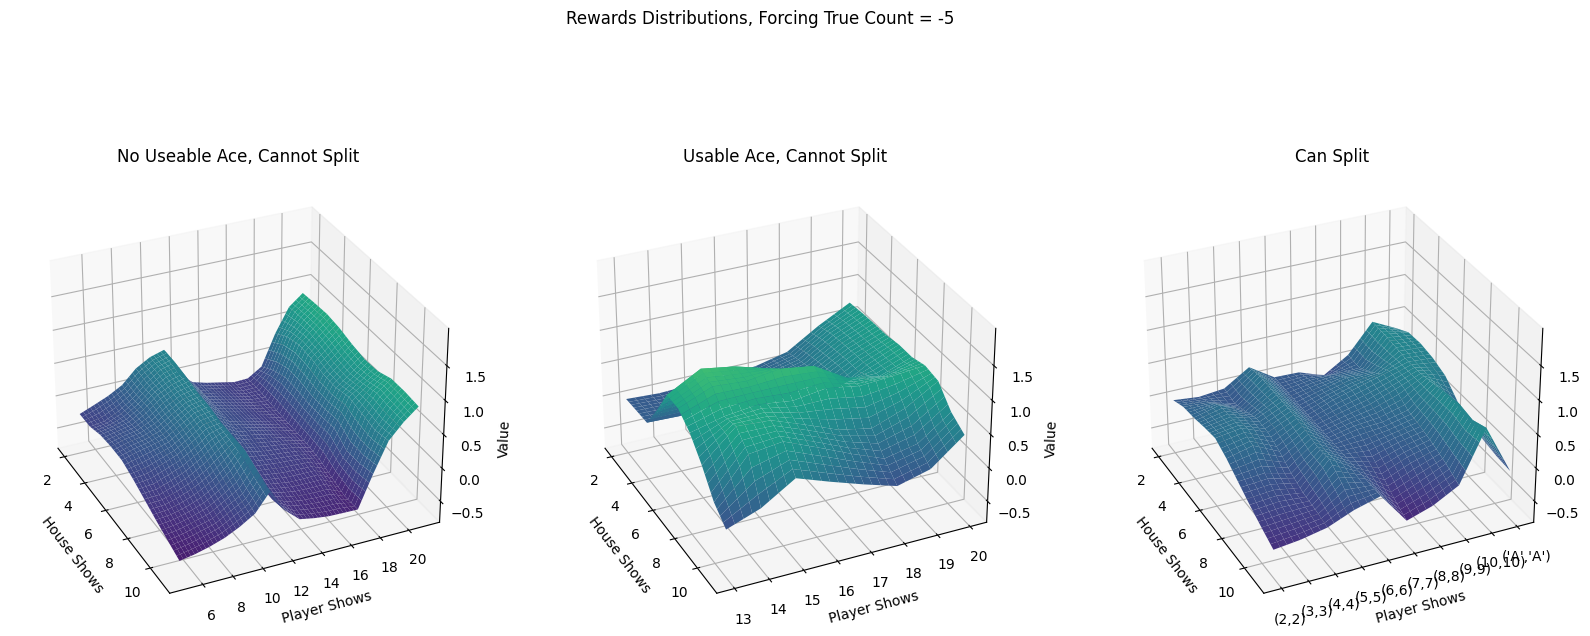

In [25]:
fig = plt.figure(figsize=(20,8))

ind = 0
count = list(all_states.keys())[ind]

fig.suptitle(f"Rewards Distributions, Forcing True Count = {count}")
ax = fig.add_subplot(131, projection="3d")
ax.set_title("No Useable Ace, Cannot Split")

plot_mesh(
    ax,
    all_states[count]["values"][0][5:,2:],
    [range(2,12),range(5,22)],
    ticks=None,
    interpolate=4,
    zlims=[min_use, max_use],
    vmin=min_use,
    vmax=max_use
)

ax = fig.add_subplot(132, projection="3d")
ax.set_title("Usable Ace, Cannot Split")

plot_mesh(
    ax,
    all_states[count]["values"][1][13:21,2:],
    [range(2,12),range(13,21)],
    ticks=None,
    interpolate=4,
    zlims=[min_use, max_use],
    vmin=min_use,
    vmax=max_use
)

ax = fig.add_subplot(133, projection="3d")
ax.set_title("Can Split")

ticks = [f"({p},{p})" if p < 11 else "('A','A')" for p in range(2,12)]
plot_mesh(
    ax,
    all_states[count]["values"][2][2:12,2:],
    [range(2,12),range(2,12)],
    ticks=ticks,
    interpolate=4,
    zlims=[min_use, max_use],
    vmin=min_use,
    vmax=max_use
)

plt.subplots_adjust(hspace=0, wspace=0.2)
plt.show()

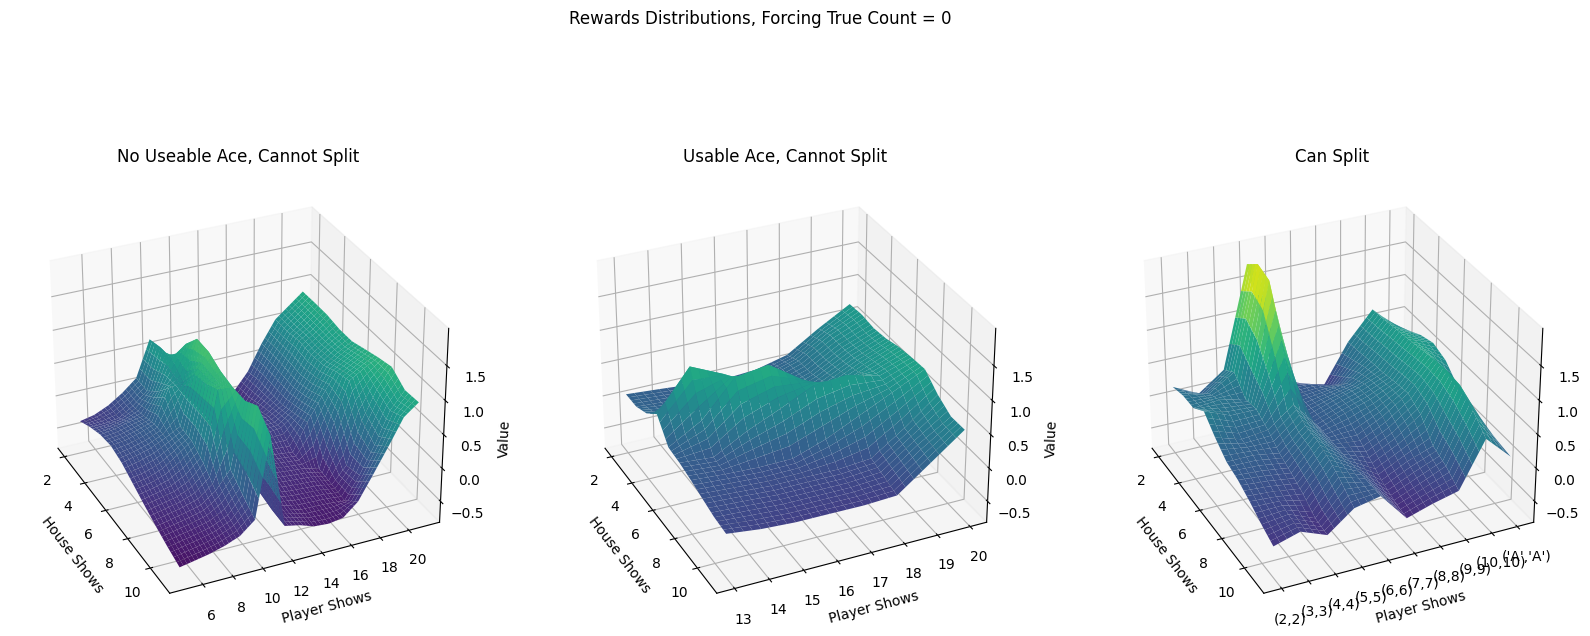

In [26]:
fig = plt.figure(figsize=(20,8))

ind = 1
count = list(all_states.keys())[ind]

fig.suptitle(f"Rewards Distributions, Forcing True Count = {count}")
ax = fig.add_subplot(131, projection="3d")
ax.set_title("No Useable Ace, Cannot Split")

plot_mesh(
    ax,
    all_states[count]["values"][0][5:,2:],
    [range(2,12),range(5,22)],
    ticks=None,
    interpolate=4,
    zlims=[min_use, max_use],
    vmin=min_use,
    vmax=max_use
)

ax = fig.add_subplot(132, projection="3d")
ax.set_title("Usable Ace, Cannot Split")

plot_mesh(
    ax,
    all_states[count]["values"][1][13:21,2:],
    [range(2,12),range(13,21)],
    ticks=None,
    interpolate=4,
    zlims=[min_use, max_use],
    vmin=min_use,
    vmax=max_use
)

ax = fig.add_subplot(133, projection="3d")
ax.set_title("Can Split")

ticks = [f"({p},{p})" if p < 11 else "('A','A')" for p in range(2,12)]
plot_mesh(
    ax,
    all_states[count]["values"][2][2:12,2:],
    [range(2,12),range(2,12)],
    ticks=ticks,
    interpolate=4,
    zlims=[min_use, max_use],
    vmin=min_use,
    vmax=max_use
)

plt.subplots_adjust(hspace=0, wspace=0.2)
plt.show()

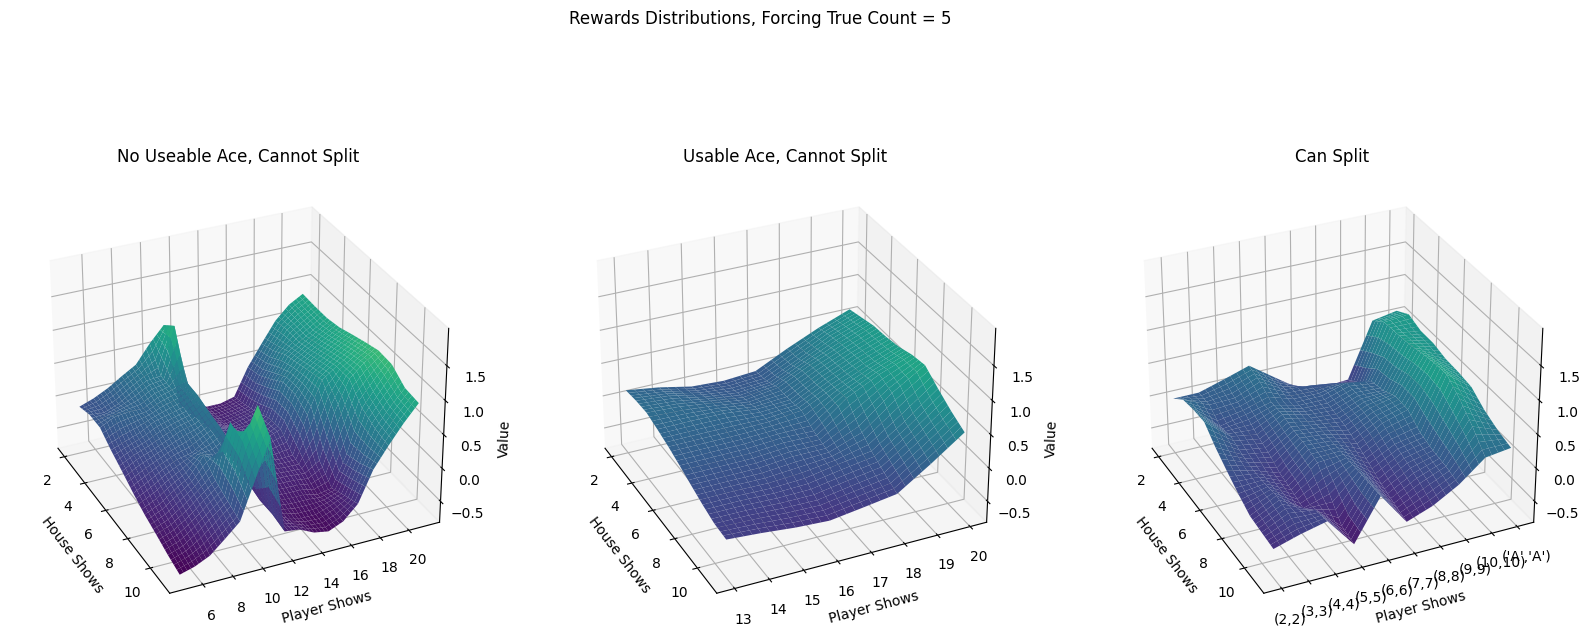

In [27]:
fig = plt.figure(figsize=(20,8))

ind = 2
count = list(all_states.keys())[ind]

fig.suptitle(f"Rewards Distributions, Forcing True Count = {count}")
ax = fig.add_subplot(131, projection="3d")
ax.set_title("No Useable Ace, Cannot Split")

plot_mesh(
    ax,
    all_states[count]["values"][0][5:,2:],
    [range(2,12),range(5,22)],
    ticks=None,
    interpolate=4,
    zlims=[min_use, max_use],
    vmin=min_use,
    vmax=max_use
)

ax = fig.add_subplot(132, projection="3d")
ax.set_title("Usable Ace, Cannot Split")

plot_mesh(
    ax,
    all_states[count]["values"][1][13:21,2:],
    [range(2,12),range(13,21)],
    ticks=None,
    interpolate=4,
    zlims=[min_use, max_use],
    vmin=min_use,
    vmax=max_use
)

ax = fig.add_subplot(133, projection="3d")
ax.set_title("Can Split")

ticks = [f"({p},{p})" if p < 11 else "('A','A')" for p in range(2,12)]
plot_mesh(
    ax,
    all_states[count]["values"][2][2:12,2:],
    [range(2,12),range(2,12)],
    ticks=ticks,
    interpolate=4,
    zlims=[min_use, max_use],
    vmin=min_use,
    vmax=max_use
)

plt.subplots_adjust(hspace=0, wspace=0.2)
plt.show()

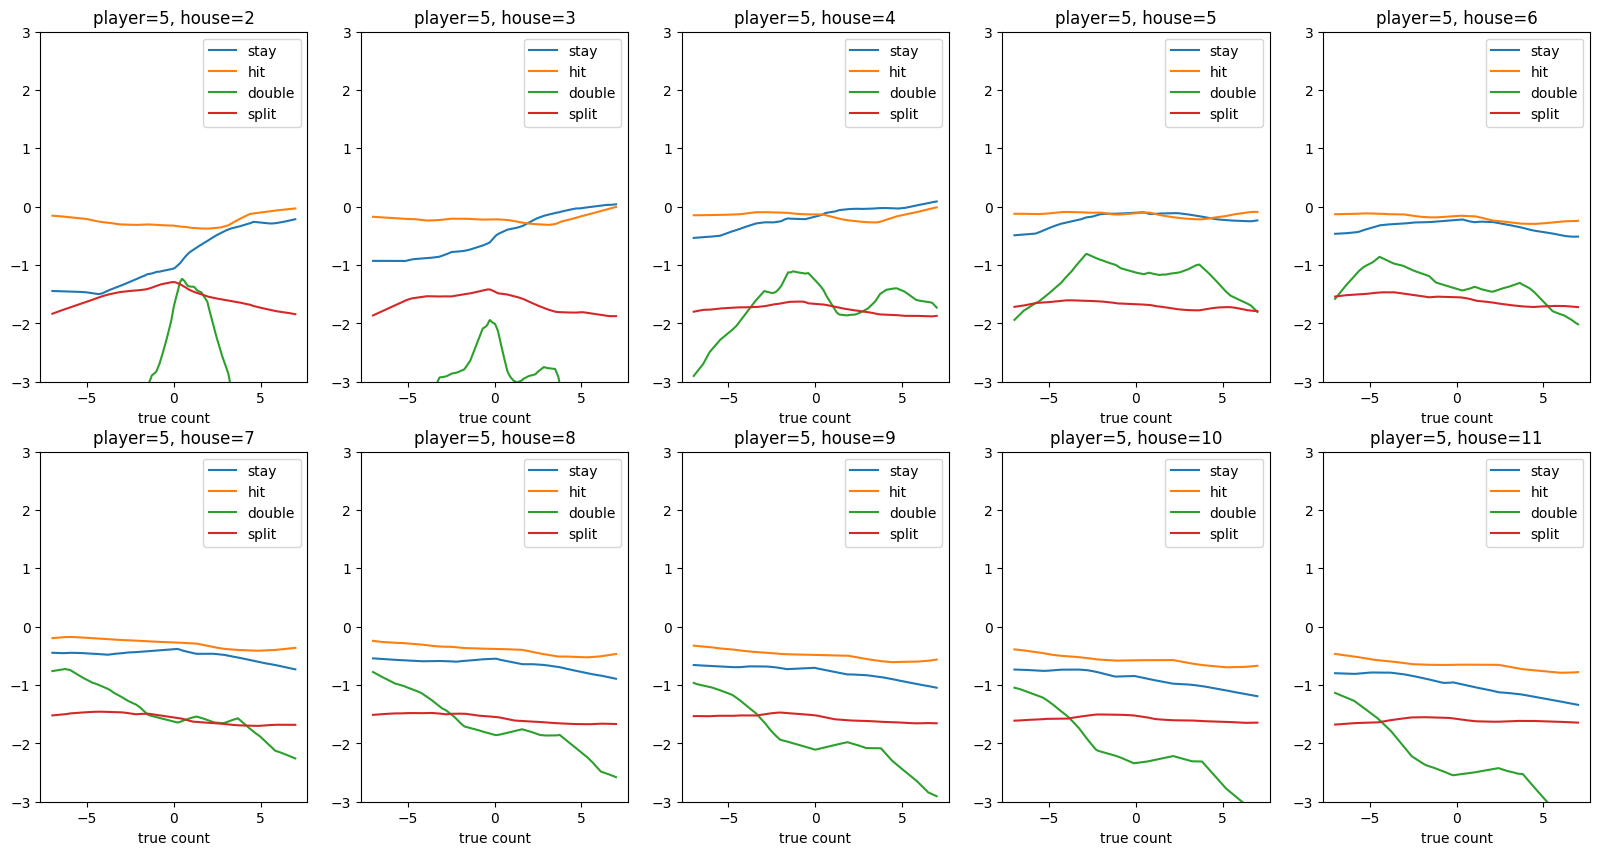

In [29]:
fig = plt.figure(figsize=(20,10))

nrows = 2
ncols = 5

player = 5
useable_ace = -1
can_split = -1
can_double = 1

for i in range(10):
    obs = []
    ax = fig.add_subplot(nrows,ncols,i+1)
    ax.set_title(f"player={player}, house={i+2}")
    for j in np.arange(-7,7.01,0.01):
        obs.append((player, i+2, useable_ace, can_split, can_double, j))
    q, _, _ = network.act(torch.tensor(obs, dtype=torch.float32))
    for i in range(4):
        ax.plot(np.arange(-7,7.01,0.01), q[:,i], label=network.moves[i])
    ax.legend()
    ax.set_xlabel("true count")
    ax.set_ylim(-3,3)
plt.show()

#### True Count Impact on Rewards

I can partition the earned rewards, following the optimal policy, by true count at the time of round start, and assess how this impacts outcome. While it's clear how our value function changes as we compare the extreme true count differences, it'd be interesting to see how this actually translates to winnings.

In [970]:
blackjack = Game(**game_hyperparams)

res = await play_games_gather_count(
    model=network,
    n_games=2_500,
    n_rounds=100,
    wagers=[1],
    game_hyperparams=game_hyperparams
)

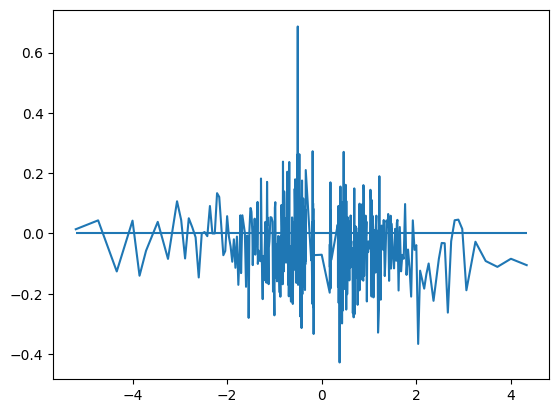

In [979]:
x = []
y = []
z = []
for count in np.unique(list(res.keys())):
    if count not in res: continue
    if len(res[count]) < 100: continue
    x.append(count)
    y.append(np.mean(res[count]))
    z.append(len(res[count]))

plt.plot(x,y)
plt.hlines(y=0, xmin=min(x), xmax=max(x))
plt.show()